Note to self: float32 is NOT enough to achieve reasonable numerical stability in the Gram-Schmidt step!

In [319]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [320]:
def decompose(signal, harmonics):
    # assumes harmonics are orthonormalized
    return torch.tensor([torch.tensor(signal).dot(torch.tensor(h)) for h in harmonics])

In [321]:
def recompose(coeffs, harmonics):
    return torch.sum(torch.stack([c * h for c, h in zip(coeffs, harmonics)]), dim=0)

In [322]:
def num_needed_for_half(nums):
    # returns the number of elements needed to reach at least half the sum of the input list
    total = sum(nums)
    half = total / 2
    running_sum = 0
    for i, num in enumerate(sorted(nums, reverse=True)):
        running_sum += num
        if running_sum >= half:
            return i + 1
    return len(nums)

In [323]:
rec_df = pd.read_csv('data/grid_rec.csv')
haar_df = pd.read_csv('data/grid_haar.csv')

In [324]:
num_nodes = 4*9

In [325]:
edges = list(map(lambda x: torch.tensor(eval(x)), rec_df[rec_df['num_nodes']==num_nodes]['edge_index'].values))

In [326]:
list(map(lambda x: x.shape, edges))

[torch.Size([2, 59]),
 torch.Size([2, 63]),
 torch.Size([2, 68]),
 torch.Size([2, 72])]

In [327]:
edge_index = torch.tensor(eval(rec_df[rec_df['num_nodes']==num_nodes]['edge_index'].values[0]))
rec_signals = torch.tensor(eval(rec_df[rec_df['num_nodes']==num_nodes]['signals'].values[0]), dtype=torch.float64)
haar_signals = torch.tensor(eval(haar_df[haar_df['num_nodes']==num_nodes]['signals'].values[0]), dtype=torch.float64)

In [328]:
def gram_schmidt(vectors):
    orthogonal = []
    for v in vectors:
        w = v.clone()
        for u in orthogonal: # each u is already normalized
            w -= torch.dot(w, u) * u
        norm = torch.norm(w)
        if norm > 1e-8:
            orthogonal.append(w / norm)
        else:
            orthogonal.append(torch.zeros_like(w))
    return torch.stack(orthogonal)

def just_norm(vectors):
    normed = []
    for v in vectors:
        normed.append(v / torch.norm(v) if torch.norm(v) > 1e-8 else torch.zeros_like(v))
    return torch.stack(normed)

rec_orth = just_norm(rec_signals)
haar_orth = just_norm(haar_signals)

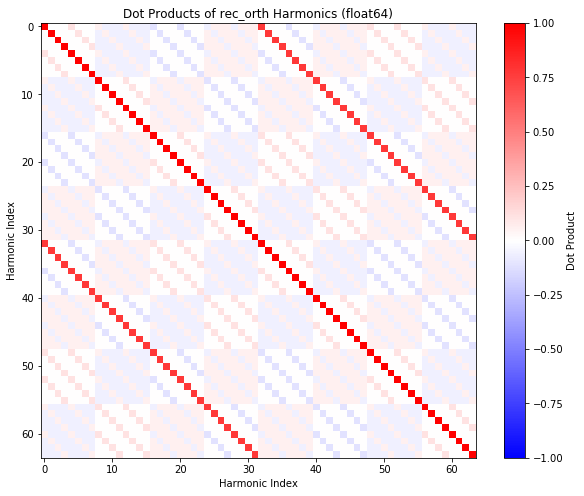

In [329]:
dot_matrix = torch.stack([torch.stack([torch.dot(h1, h2) for h2 in rec_orth]) for h1 in rec_orth])
plt.gcf().set_size_inches(10, 8)
plt.imshow(dot_matrix.numpy(), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(label='Dot Product')
plt.title('Dot Products of rec_orth Harmonics (float64)')
plt.xlabel('Harmonic Index')
plt.ylabel('Harmonic Index')
plt.show()

In [330]:
def get_laplacian(edge_index, num_nodes):
    # edge_index: shape [2, num_edges]
    adj = torch.zeros((num_nodes, num_nodes), dtype=torch.float64)
    adj[edge_index[0], edge_index[1]] = 1
    adj[edge_index[1], edge_index[0]] = 1  # undirected graph
    deg = torch.diag(adj.sum(dim=1))
    laplacian = deg - adj
    return laplacian

laplacian = get_laplacian(edge_index, num_nodes)

In [331]:
eigvals, eigvecs = torch.eig(laplacian, eigenvectors=True)
eigvals = eigvals[:, 0]  # take the real part of eigenvalues
sorted_indices = torch.argsort(eigvals)
eigvecs_sorted = eigvecs[:, sorted_indices]
eigvals_sorted = eigvals[sorted_indices]
eigvec_list = [eigvecs_sorted[:, i] for i in range(eigvecs_sorted.shape[1])]

In [332]:
def do_plot(eigvec_list, harmonics, title):
    
    decompositions = [decompose(eigvec, harmonics) for eigvec in eigvec_list]
    recompositions = [recompose(decomp, harmonics) for decomp in decompositions]
    
    # normalize the recompositions
    recompositions = [r/np.linalg.norm(r) if np.linalg.norm(r) > 1e-8 else np.zeros_like(r) for r in recompositions]

    decompositions_plot = np.stack([np.abs(decomp) for decomp in decompositions]).T # each row is a harmonic, each column is an eigenvector
    recomp_quality = [torch.dot(recomp, eigvec) for recomp, eigvec in zip(recompositions, eigvec_list)]
    
    # Add subplot for recomp_quality
    fig, axs = plt.subplots(2, 1, figsize=(3.5, 5), gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(title, fontsize=16, y=1.02)

    # Top: decomposition plot
    im = axs[0].imshow(decompositions_plot, aspect='auto', cmap='viridis')
    axs[0].invert_yaxis()
    fig.colorbar(im, ax=axs[0], label='Coefficient Magnitude')
    axs[0].set_xlabel('Eigenvector Index')
    axs[0].set_ylabel('Signal Index')
    axs[0].set_title('Dot Products')

    # Middle: recomp_quality plot
    """axs[1].plot([1-float(q) for q in recomp_quality], marker='o')
    axs[1].set_xlabel('Eigenvector Index')
    axs[1].set_ylabel('Reconstruction Loss')
    axs[1].set_title('Reconstruction Loss per Eigenvector (1 - Dot Product)')
    axs[1].grid(True)"""

    # Bottom: num_needed_for_half plot (assuming still normalized)
    fracs_for_halves = [num_needed_for_half(decomp.pow(2)) / len(decompositions[0]) for decomp in decompositions]
    axs[1].plot(fracs_for_halves, marker='o')
    print(sum(fracs_for_halves) / len(fracs_for_halves))
    axs[1].set_xlabel('Eigenvector Index')
    axs[1].set_ylabel('Component Fraction')
    axs[1].set_title('Half-Norm Components')
    axs[1].grid(True)
    axs[1].set_ylim(bottom=0)
    
    

    plt.tight_layout()
    plt.show()

/home/bsw38/.conda/envs/benchmark_gnn_2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


0.10199652777777778


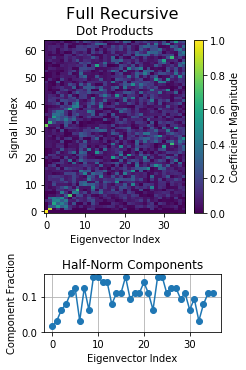

In [333]:
do_plot(eigvec_list, rec_orth, 'Full Recursive')

/home/bsw38/.conda/envs/benchmark_gnn_2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


0.15147569444444445


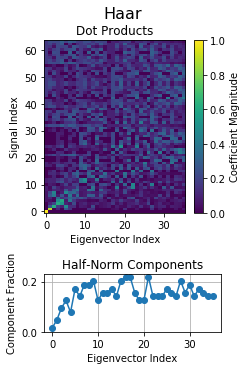

In [334]:
do_plot(eigvec_list, haar_orth, 'Haar')